<h1><center>Projet ACV</center></h1>

# Imports

In [1]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

import numpy as np
import cv2 # librairie OpenCV

# Filtres statiques

In [2]:
# Conversion de l'image de BGR en RGB

def to_RGB(image):
    """convertit l'image de BGR en RGB"""
    img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return img

In [3]:
# Conversion en HSV

def to_HSV(image):
    """convertit l'image de BGR en HSV"""
    img = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    return img

In [4]:
def filtre_miroir_vertic(image):
    '''Applique un filtre miroir à la verticale de l'image entrée en input'''
  
    height, width = image.shape[:2]
    image_miroir = np.zeros((height, width, 3), 'uint8')
    demi_image = image[:,0:width//2]
    demi_image_miroir = np.flip(demi_image, axis = 1)
    image_miroir[:,:width//2] = demi_image
    image_miroir[:,width//2:] = demi_image_miroir

    return image_miroir

In [5]:
def filtre_miroir_horiz(image):
    '''Applique un filtre miroir à l'horizontale de l'image entrée en input'''
    # A FAIRE
    height, width = image.shape[:2]
    image_miroir = np.zeros((height, width, 3), 'uint8')
    demi_image = image[0:height//2,:]
    demi_image_miroir = np.flip(demi_image, axis = 0)
    image_miroir[0:height//2,:] = demi_image
    image_miroir[height//2:,:] = demi_image_miroir

    return image_miroir

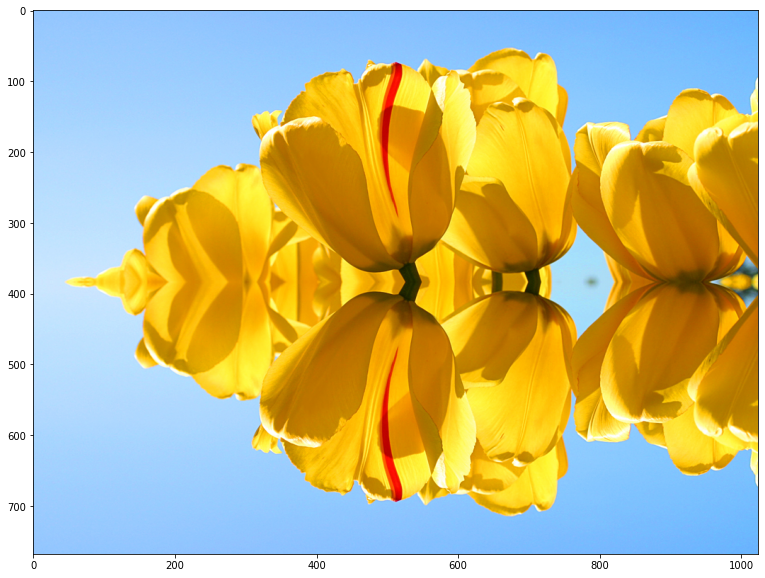

In [8]:
img = plt.imread('../../data/tulips.jpg')

plt.figure()
plt.imshow(filtre_miroir_horiz(img))

In [ ]:
def filtre_flou(image):
    '''Applique un filtre flou à l'image entrée en input par flou gaussien'''
    blurred = cv2.GaussianBlur(image,(19,19),0)
    return blurred

In [ ]:
def filtre_gray(image):
    '''Transforme l'image entrée en input en échelle de gris'''
    grayscale = np.zeros((image.shape[0], image.shape[1], 3), 'uint8') #création d'une image en 3D vide
    grayscale[:,:,0] = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    grayscale[:,:,1] = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    grayscale[:,:,2] = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return grayscale 

In [ ]:
def filtre_sepia(image):
    '''Applique un filtre sepia à l'image entrée en input'''
    img_sepia = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    for pixel in img_sepia[:,:,0]:
        pixel[0]=31
    return img_sepia
# NE MARCHE PAS

In [ ]:
def filtre_pixel(image):
    """Pixelise l'image"""
    height,width = image.shape[:2]
    img = image[0:height:5, 0:width:5] # le 5 correspond au pas (nb de pixels à sauter)
    img = cv2.resize(img, dsize=(width, height))
    return img

In [ ]:
# A IMPLEMENTER EN FONCTION ET TESTER - CARTOON
tulips = plt.imread('data/tulips.jpg')
tublur = cv2.medianBlur(tulips, 29)

# We'll cover Canny edge detection and dilation shortly
edge = cv2.Canny(tublur, 10, 150)
kernel = np.ones((5,5), np.uint8)
edge = cv2.dilate(edge, kernel, iterations = 1)
tublur[edge==255] = 0

plt.figure()

plt.subplot(1,2,1)
plt.imshow(tulips)
plt.title('original')

plt.subplot(1,2,2)
plt.imshow(tublur)
plt.title('cartoonified')

In [ ]:
# A IMPLEMENTER EN FONCTION ET TESTER - SI BESOIN - FILTERING ET EDGE DETECTION
img = cv2.imread('data/messi.jpg', cv2.IMREAD_GRAYSCALE)
edge = cv2.Canny(img, 100, 200)
 
plt.figure()

plt.subplot(121)
plt.title('Original Image')
plt.imshow(img, cmap='gray')

plt.subplot(122)
plt.title('Edge Image')
plt.imshow(edge, cmap='gray')

# Quadrillage

In [ ]:
def quadrillage_filtre(image, filtres:list):
    '''Pour l'image donnée en entrée, la fonction affiche un quadrillage en 3 par 3 de l'image transformée par les filtres.
    Les filtres sont fournis en tant que liste de variables.'''

    newheight = image.shape[0]//3
    newwidth = image.shape[1]//3
    img_resized = cv2.resize(image, dsize=(newwidth,newheight)) # on resize l'image de départ en la divisant par 3. attention : width avant height
    quadrillage = np.zeros((image.shape[0], image.shape[1], 3), 'uint8') #création d'un quadrillage vide


    def no_filter(image): # on crée un filtre pour afficher l'image originale
        return image  

    filtres = filtres[:4] + [no_filter] + filtres[4:] # on veut que l'image originale soit au milieu du quadrillage
    for y in range(3): # pour chaque colonne
        for x in range(3): # pour chaque ligne
            filtre = filtres[3*y+x] # sélection du filtre à appliquer parmi la liste
            img_filtree = filtre(img_resized)
            quadrillage[y*newheight:(y+1)*newheight,x*newwidth:(x+1)*newwidth] = img_filtree

    return quadrillage

# METTRE LA LISTE DES FILTRES DANS LA FONCTION
list_filtres = [filtre_miroir_horiz,filtre_miroir_vertic,to_HSV,to_RGB,filtre_gray,filtre_sepia,filtre_pixel,filtre_flou]
quadrillage = quadrillage_filtre(tulips, list_filtres)

plt.figure()
plt.imshow(quadrillage)